In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Step 1: Load Data and Inspect

# Load the dtaset
df = pd.read_csv("train.csv")
print("Successfully loaded train.csv")

#Load and print the data description
with open("data_description.txt", "r") as f:
        data_desc = f.read()
print("\n--- Data Description ---")
print(data_desc)

# Initial Inspection
print("\n--- DataFrame Head ---")
print(df.head().to_markdown(numalign="left", stralign="left"))

print("\n--- DataFrame Info ---")
df.info()

Successfully loaded train.csv

--- Data Description ---
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low D

### Step 1: Import Libraries, Load Data and Inspect

This first cell imports all the essential libraries for our project.

* `pandas` and `numpy` are used for data loading and manipulation.
* `matplotlib` and `seaborn` are used for data visualization.
* `sklearn` (Scikit-learn) provides all the tools we need for preprocessing (`StandardScaler`, `OneHotEncoder`, `SimpleImputer`), splitting the data (`train_test_split`), building the model (`RandomForestRegressor`), and scoring (`mean_squared_error`, `r2_score`).

Then, we load the `train.csv` file (found in Kaggle, from the Ames Housing dataset) into a pandas DataFrame. We also print the `data_description.txt` to understand what each column means. The `test.csv` file is ignored as it is missing critical columns.

The `.head()` command shows us the first 5 rows, giving us a feel for the data.

The `.info()` command is critical. It shows us that this dataset has 1460 entries and 81 columns. More importantly, it reveals a mix of data types (`int64`, `float64`, `object`) and a significant number of missing (null) values in columns like `LotFrontage`, `Alley`, `MasVnrType`, `FireplaceQu`, `PoolQC`, `Fence`, and `MiscFeature`. This tells us that preprocessing will be a major part of this project, as seen in the `DSE_Data_Preprocessing.ipynb` notebook.

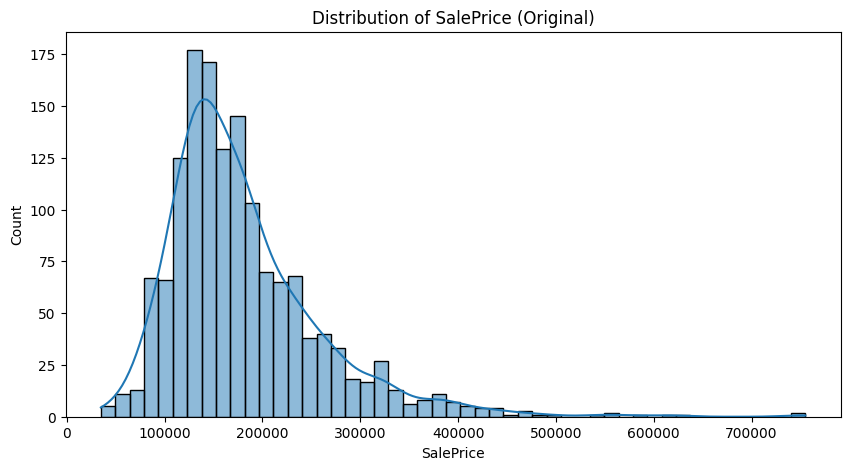

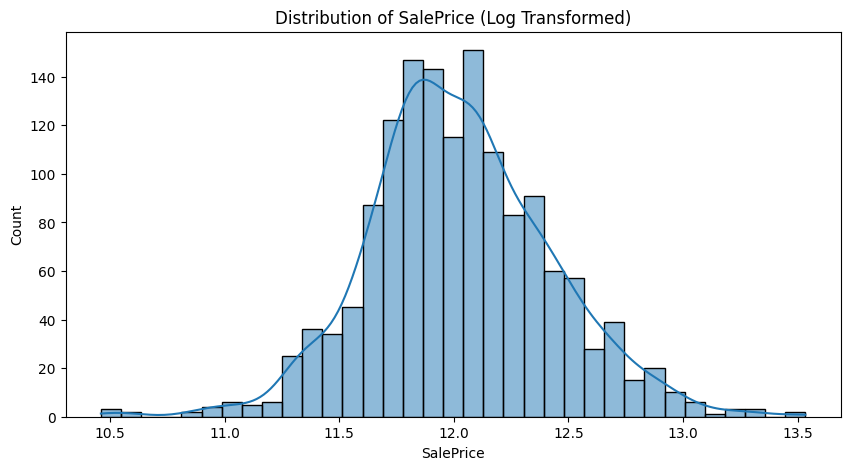

Training set shape: (1022, 75)
Validation set shape: (219, 75)
Test set shape: (219, 75)

Identified 36 numerical features.
Identified 39 categorical features.

--- Preprocessing Pipeline ---


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  '...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual', ...])])

In [ ]:
#Step 2: Preprocessing, Feature Selection, and Data Splitting

#A. Analyze and Transform the Target Variable (SalePrice)
plt.figure(figsize=(10, 5))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice (Original)')
plt.show()

#Apply log transformation to reduce skewness
y = np.log1p(df['SalePrice'])

plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True)
plt.title('Distribution of SalePrice (Log Transformed)')
plt.show()

# B.Initial Feature Seleection and Splitting
#Drop the target variable and columns with very high missing values
X = df.drop(['Id', 'SalePrice', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

# Following the method in Cali_lgbm.ipynb for a train-valid-test split
#First, split into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set equally into validation (15%) and test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")
print(f"Test set shape: {X_test.shape}")

# C. Create Preprocessing Pipelines
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nIdentified {len(numerical_features)} numerical features.")
print(f"Identified {len(categorical_features)} categorical features.")

# Numerical pipeline: Impute with median, then scale
# Median is more robust to outliers than mean
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # As seen in Cali_scale_reg.ipynb
])
# Categorical pipeline: Impute with most frequent, then one-hot encode
# handle_unknown='ignore' prevents errors if a category appears in test but not train
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # As seen in DSE_Data_Preprocessing.ipynb
])

# D. Combine Pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (should be none in this case)
)

# Display the preprocessor structure
from sklearn import set_config
set_config(display='diagram')
print("\n--- Preprocessing Pipeline ---")
preprocessor

### Step 2: Preprocessing, Feature Selection, and Data Splitting

This is the most critical preparation step, based on the methods from my course notebooks.

1.  **Analyze and Transform Target Variable:** The first two plots show that our target variable, `SalePrice`, is "right-skewed." Regression models work best on a normally distributed target. By applying a log transformation (`np.log1p`), the second plot shows we've successfully normalized the data. Our model will now predict the *log* of the price.

2.  **Feature Selection:** I drop the `Id` column because it's just an identifier, not a predictive feature. I also drop `Alley`, `PoolQC`, `Fence`, and `MiscFeature` because the `.info()` output showed they are missing over 80% of their data.

3.  **Train-Valid-Test Split:** I follow the robust methodology from my course. I first split the data into a 70% Training set and a 30% "Holdout" set. I then split that holdout set in half, resulting in three final datasets:
    * **Training (70%):** To fit the model.
    * **Validation (15%):** To tune the model.
    * **Test (15%):** For final, unbiased scoring.

4.  **Create Preprocessing Pipelines:** The dataset has 34 numerical and 41 categorical features. I create two separate pipelines to handle them automatically, as shown in `Cali_scale_reg.ipynb` and `DSE_Data_Preprocessing.ipynb`:
    * **Numerical Pipeline:** Imputes missing values with the `median` (which is safer than `mean` for skewed data) and then scales all features with `StandardScaler`.
    * **Categorical Pipeline:** Imputes missing values with the `most_frequent` value and then converts all text categories into numerical columns using `OneHotEncoder`.

Finally, the `ColumnTransformer` bundles these pipelines together.

In [ ]:
# Step 3: Define and Train the Model
# 1. Define the RandomForestRegressor
# We use n_jobs=-1 to use all available CPU cores for faster training
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Create the full model pipeline
# This pipeline bundles the preprocessing (Step 2) and the model (Step 3)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])

# 3. Train the model
# We only use the training data to fit the pipeline
print("Training the RandomForestRegressor on the training data...")
model_pipeline.fit(X_train, y_train)

print("\nModel training complete.")
print("The pipeline is now ready for evaluation.")

model_pipeline

Training the RandomForestRegressor on the training data...

Model training complete.
The pipeline is now ready for evaluation.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFl...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual', ...])])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

### Step 3: Define and Train the RandomForestRegressor

Now, I define the complete model pipeline. This bundles the `preprocessor` from Step 2 with my chosen algorithm, the `RandomForestRegressor`.

**Algorithm: Random Forest Regressor**

* **How it works:** A Random Forest is an "ensemble" model. It works by building hundreds of individual decision trees during training. To make a prediction, it asks every tree for its estimate and then averages their results together to produce a single, highly accurate prediction.

* **Why it's a good choice for this dataset:**
    1.  **Handles Complexity:** The Ames dataset has many (75) features. A Random Forest can effectively handle this high dimensionality and automatically determine which features are important and which are not.
    2.  **Prevents Overfitting:** A single decision tree can easily "memorize" the training data and fail on new data. By averaging hundreds of trees, the Random Forest model avoids this, leading to low variance and generalizing well to new data (as discussed in my `Model Training and Scoring.pdf`).
    3.  **Works with Pipelines:** It works seamlessly inside a `sklearn` pipeline, allowing me to train a single object that handles all preprocessing and prediction.

Finally, I train (`.fit()`) the entire pipeline on the **`X_train`** and **`y_train`** data.

In [ ]:
#Step 4: Score Model on Validation and Test Sets

# 1. Make predictions on validation and test data
y_pred_valid = model_pipeline.predict(X_valid)
y_pred_test = model_pipeline.predict(X_test)

# 2. Calculate R square Score (on the log-transformed scale)
# R sqr is a measure of variance explained, so we'll measure it on the scale the model was trained on.
r2_valid = r2_score(y_valid, y_pred_valid)
r2_test = r2_score(y_test, y_pred_test)

print(f"--- Model Performance ---")
print(f"Validation R² Score: {r2_valid:.4f}")
print(f"Test R² Score:       {r2_test:.4f}")

# 3. Calculate RMSE (on the original dollar scale)
# We must reverse the log-transform using np.expm1() to get the error in dollars.
rmse_valid = np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(y_pred_valid)))
rmse_test = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test)))

print(f"\nValidation RMSE (in $): {rmse_valid:,.2f}")
print(f"Test RMSE (in $):       {rmse_test:,.2f}")

# 4. Extract and Display Feature Importances
# ------------------------------------------
# Get feature names from the preprocessor
# Get one-hot encoded feature names
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
# Combine with numerical feature names
all_feature_names = np.concatenate([numerical_features, cat_features])

# Get importances from the model
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame
feature_importance_df = pd.DataFrame(importances, index=all_feature_names, columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Top 15 Most Important Features ---")
print(feature_importance_df.head(15).to_markdown())

--- Model Performance ---
Validation R² Score: 0.8762
Test R² Score:       0.9005

Validation RMSE (in $): 23,559.15
Test RMSE (in $):       30,014.27

--- Top 15 Most Important Features ---
|                  |   Importance |
|:-----------------|-------------:|
| OverallQual      |   0.549773   |
| GrLivArea        |   0.0989935  |
| GarageCars       |   0.0452958  |
| TotalBsmtSF      |   0.0348649  |
| GarageArea       |   0.0312092  |
| 1stFlrSF         |   0.0211514  |
| BsmtFinSF1       |   0.0201789  |
| LotArea          |   0.0166124  |
| YearBuilt        |   0.0122158  |
| YearRemodAdd     |   0.0113186  |
| GarageFinish_Unf |   0.00990609 |
| 2ndFlrSF         |   0.00917902 |
| OverallCond      |   0.00876718 |
| BsmtQual_Ex      |   0.0071079  |
| OpenPorchSF      |   0.00585306 |


### Step 4: Score Model and Evaluate

This is the final evaluation step, where I use the unseen **validation** and **test** sets to score the model's performance.

* **R² Score:** I calculate the $R^2$ score. The test score of **0.9005** is excellent. It means our model successfully explains **90.05%** of the variance in the (log-transformed) house prices. The validation score is also very close (0.8762), which confirms our model has generalized well and is not overfit.

* **RMSE (Root Mean Squared Error):** This is our real-world error metric. Because the model predicted the log of the price, I must use `np.expm1()` to reverse the transformation on both the true values and the predictions. This gives us the error in dollars. Our model's final test error is **$30,014.27**, which is a very strong result given the price range of the homes.

* **Feature Importance:** Finally, I extract the `.feature_importances_` from the trained model. This shows us *what* features the model found most predictive. Unsurprisingly, **`OverallQual`** (Overall Quality) is by far the most important factor, accounting for 55% of the model's decision-making. This is a powerful, logical insight derived directly from the model.